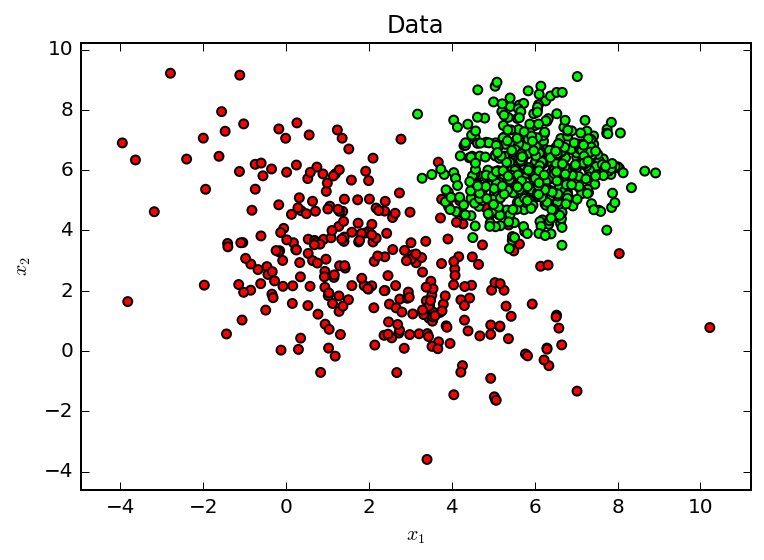

In [28]:
import numpy as np
import collections
import scipy
import math
import matplotlib.pyplot as plt 
from sklearn import neighbors, svm
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Para graficar, simulando el ejemplo de nearest neighbor de sklearn
cmap_light = ListedColormap(['#FFAAAA', '#00FF00'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

x1,x2,which_class  = np.genfromtxt('datos_clasificacion.dat',skip_header=1, usecols=(0,1,2), unpack = True)
x = np.array([x1,x2])

#MESHGRID aprendiendo!
h = .02
x_min, x_max = x[0].min() - 1, x[0].max() + 1
y_min, y_max = x[1].min() - 1, x[1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

plt.scatter(x[0], x[1], c=which_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Data')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()


${\bf P1)}$ 

En esta sección debemos entrenar 3 clasificadores usando los datos vistos anteriormente: recordemos que tenemos nuestro vector $target$, o sea, el que contiene los labels $y_{i} = \{1,2\}$ (en el código, clase 1 y clase 2); y el vector de los features, $x =(x_{1}\quad x_{2} )^{T} $.

PAra crear/entrenar nuestro clasificador de regresión lineal, lo hacemos fiteando una línea recta:

\begin{align}
 Y_i &= \alpha +  \beta \dot X_{1_{i}} + \gamma \dot X_{2_{i}}\\
\rightarrow \vec{y} &= \underbrace{\begin{pmatrix} 1 & X_{1_{i}} & X_{2_{1}} \\ 1 & X_{1_{2}} & X_{2_{2}}\\  \vdots & \vdots & \vdots \\ 1 & X_{1_{800}}  & X_{2_{800}}\end{pmatrix}}_{M} \cdot \underbrace{\begin{pmatrix} \hat{\alpha} \\ \hat{\beta} \\ \hat{\gamma} \end{pmatrix}}_{\vec{\theta}}\\
\rightarrow \vec{\theta} &= (M^{T}\cdot M)^{-1} M^{T} \vec{y} 
\end{align}

La ${\bf \text{decision boundary}}$ la obtenemos de la siguiente forma:

\begin{align}
  M\cdot\vec{\theta} &= \frac{3}{2} \\
  \rightarrow  X_{2} &= -X_{1}\underbrace{\frac{\beta}{\gamma}}_{B} + \underbrace{\frac{3}{2\gamma} - \frac{\alpha}{\gamma}}_{A}  
\end{align}

Por tanto, al momento de predecir, asignaremos puntos a la clase 2 si $X_{2} + X_{1}B - A \geq 0$ y a la clase 1 en el caso contrario. 

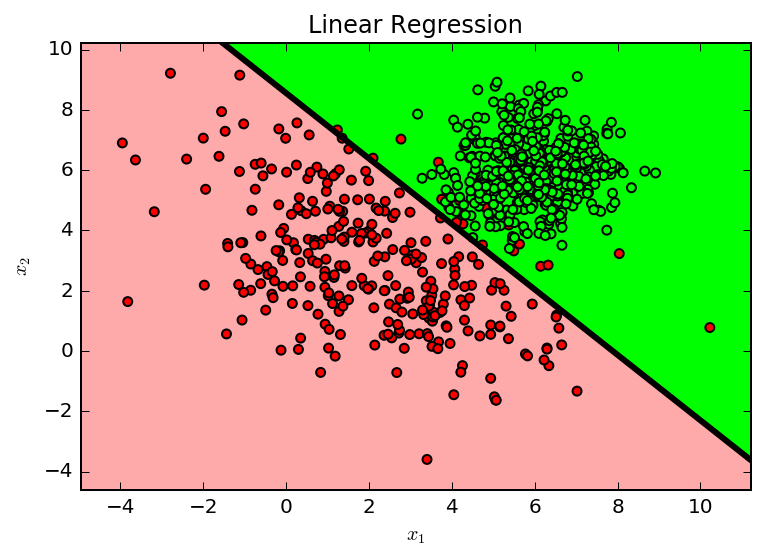

In [29]:
#a) Regresion lineal 

def train_linear_regression(y,x):
    #adjust poly order 1
    matrix = np.concatenate([np.ones(len(y)),x[0],x[1]],axis=0).reshape(3,len(y)).T
    param = np.linalg.solve(np.dot(matrix.T,matrix), np.dot(matrix.T,y) )
    return param

def test_linear_regression(x,params):
    aux = x.T[1] - (-params[0] + 1.5 - x.T[0]*params[1])/params[2]
    Z = np.zeros(len(aux))
    for i in range(len(aux)):
        if aux[i]>=0:
           Z[i]= 2
        else: 
           Z[i] = 1
    return Z
        
params = train_linear_regression(which_class,x)    

# Decision bound
x_bound = np.linspace(-4,12,10000)
decision_bound = (-params[0] + 1.5 - x_bound*params[1])/params[2]

Z = test_linear_regression(np.c_[xx.ravel(), yy.ravel()],params)
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.plot(x_bound, decision_bound,'k-',lw=3)
plt.scatter(x[0], x[1], c=which_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Linear Regression')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()




Como vemos, es una la decision boundary es una línea recta en el plano de los features, tal como muestra la ecuación obtenida previamente!


Para LDA y QDA la teoría es similar: Usando el teorema de Bayes, escribimos la probabilidad que buscamos maximizar (la probabilidad de la clase dado features) como:

\begin{align}
 p(k \text{ class | }  x) \propto \underbrace{\Pi_{k}}_{prior} \cdot \underbrace{p(x \text{ | $k$ class} )}_{likelihood}
\end{align}

Ahora si decimos que la probabilidad de los features, $x$, dada la clase ($likelihood$) proviene de una gaussiana multivariada:

\begin{align}
 p(x \text{ | $k$}) = \frac{1}{(2\pi)^{p/2}|\Sigma_{k}^{-1}|^{1/2}} \exp \left \{ -\frac{1}{2}[ (x - \mu_{k})^T {\Sigma_{k}}^{-1} (x - \mu_{k}) ] \right \}
\end{align}

fácilmente obtendríamos la probabilidad que nos interesa si tendríamos los parámetros que la definen ($\mu_{k}$ y $\Sigma_{k}$) y la probabilidad a priori de la clase. 

El método LDA asume que los features provienen de gaussianas multivariadas, con medias distintas ($\mu_1$ y $\mu_2$ para las respectivas clases), pero matrices de covarianza iguales, es decir, $\Sigma = \Sigma_1 = \Sigma_2$, y todos los parámetros los debemos estimar del sample de la siguiente manera:

\begin{align}
 &\text{Dado}  \quad x_k=\begin{pmatrix} X_{1=k} \\ X_{2=k} \end{pmatrix}\\
 &\text{Medias:} \quad \hat{\mu}_{k} =\begin{pmatrix} \hat{\mu}_{x_1=k} \\ \hat{\mu}_{x_2=k}\end{pmatrix} =\frac{1}{n_k}\begin{pmatrix}  \sum\limits_{i:x_1=k}X_{i} \\ \sum\limits_{i:x_2=k}X_{i} \end{pmatrix} \\
&\text{ Matriz Covarianza clase k:}  \quad \hat{\Sigma}_{k} = \frac{(x_{k} -\hat{\mu}_{k})(x_{k} - \hat{\mu}_{k})^T}{n_{k} -1 }  \\
 &\text{Matriz Covarianza única:} \quad  \hat{\Sigma} = \frac{\sum\limits_{i=1}^{k} (n_{i} - 1) \hat{\Sigma}_{i} }{N-k}\\
 &\text{Probabilidad a priori clase k:} \quad \hat{\Pi}_{k} = \frac{n_{k}}{N} \\
\end{align}

con $N$ el número total del sample y $n_k$ el número de elementos de la clase $k$. A partir de lo anterior, derivamos las ${\bf  \text{decision boundary }} $ de LDA y QDA (igual que en LDA, pero ahora usamos las matrices de covarianza estimadas para cada clase [no es ${\bf única}$ ]):

\begin{align}
 &\text{LDA boundary decision:}\\
 &\underbrace{X^T}_{\begin{pmatrix} X_{1} \\ X_{2} \end{pmatrix}^{T}} \underbrace{\hat{\Sigma}^{-1} (\hat{\mu}_{1} - \hat{\mu}_{2})}_{\vec{\alpha} = \begin{pmatrix} \alpha_{1} \\ \alpha_{2} \end{pmatrix}  } = \underbrace{-\log{\underbrace{\frac{\hat{\Pi}_1}{\hat{\Pi}_2}}_{\text{priors}}} + \frac{1}{2} (\hat{\mu}_1 + \hat{\mu}_2)^T \hat{\Sigma}^{-1} (\hat{\mu}_1 - \hat{\mu}_2)}_{\beta} \\
 &\rightarrow X_2 = -X_1\cdot\frac{\alpha_1}{\alpha_2} + \frac{\beta}{\alpha_2}\\\\
  &\text{QDA boundary decision:}\\
 & \underbrace{-\frac{1}{2}\log{\frac{|\hat{\Sigma}_1|}{|\hat{\Sigma}_2|}} + \log{\frac{\hat{\Pi}_1}{\hat{\Pi}_2}}  -\frac{1}{2}(\hat{\mu}_{1}^T\hat{\Sigma}_{1}^{-1}\hat{\mu}_{1} - \hat{\mu}_{2}^{T}\hat{\Sigma}_{2}^{-1}\hat{\mu}_{2}  ) }_{F} 
 +[X^T (\underbrace{-\frac{1}{2} \left[ \hat{\Sigma}_{1}^{-1} - \hat{\Sigma}_{2}^{-1} \right ]}_{\begin{pmatrix} A & \frac{C}{2} \\ \frac{C}{2} & B \end{pmatrix} }) X] + X^{T} (\underbrace{\hat{\Sigma}_{1}^{-1}\hat{\mu}_{1} - \hat{\Sigma}_{2}^{-1}\hat{\mu}_{2}}_{\begin{pmatrix} D \\ E \end{pmatrix}}) = 0 \\
 &\rightarrow AX_{1}^2 + BX_{2}^2 + CX_{1}X_{2} + DX_{1} + EX_{2} + F = 0
\end{align}

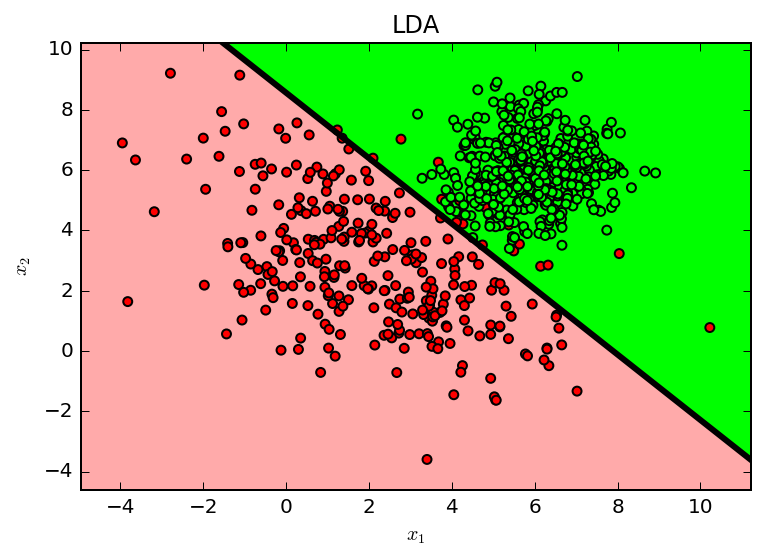

In [30]:
#LDA

#we estimate mean, covariance and the probability of the class k

def train_LDA(y,x):
    total_sample = float(len(y))
    total_class1 = float(len(y[y==1]))
    total_class2 = float(len(y[y==2]))

    #from elements of statitiscal learning

    prob_class1 = total_class1/total_sample
    prob_class2 = total_class2/total_sample

    mean_class1 = np.array([np.sum(x[0][y==1])/total_class1,np.sum(x[1][y==1])/total_class1])
    mean_class2 = np.array([np.sum(x[0][y==2])/total_class2,np.sum(x[1][y==2])/total_class2])

    #vector de datos - mean

    Xcorr_class1 = np.array([x[0][y==1] - mean_class1[0],x[1][y==1] - mean_class1[1]])
    Xcorr_class2 = np.array([x[0][y==2] - mean_class2[0],x[1][y==2] - mean_class2[1]])

    cov_class1 = Xcorr_class1.dot(Xcorr_class1.T)
    cov_class2 = Xcorr_class2.dot(Xcorr_class2.T)

    cov_all_class = (cov_class1 + cov_class2)/(total_sample - 2) # two classes!

    coeffs = np.dot(np.linalg.inv(cov_all_class),(mean_class1 - mean_class2))
    
    prob_class = np.array([prob_class1,prob_class2])
    mean_class = np.array([mean_class1,mean_class2])
    sigma_class = np.array([cov_class1,cov_class2])
    return coeffs,prob_class,mean_class,cov_all_class,sigma_class

def test_LDA(x,coeffs,prob_class,mean_class,sigma):
    prob_class1, prob_class2 = prob_class[0],prob_class[1]
    mean_class1, mean_class2 = mean_class[0],mean_class[1]
    aux = x.T[1] - (-x.T[0]*coeffs[0]  - np.log(prob_class1/prob_class2) + 0.5*np.dot((mean_class1 + mean_class2).T, np.dot(np.linalg.inv(sigma),(mean_class1 - mean_class2)) ))/coeffs[1] 
    Z = np.zeros(len(aux))
    for i in range(len(aux)):
        if aux[i]>=0:
           Z[i]= 2
        else: 
           Z[i] = 1
    return Z
    
coeffs, prob_class, mean_class, sigma_all,sigma_class = train_LDA(which_class,x)

decision_bound_LDA =(-x_bound*coeffs[0]  - np.log(prob_class[0]/prob_class[1]) + 0.5*np.dot((mean_class[0] + mean_class[1]).T, np.dot(np.linalg.inv(sigma_all),(mean_class[0] - mean_class[1])) ))/coeffs[1]

Z = test_LDA(np.c_[xx.ravel(), yy.ravel()],coeffs,prob_class,mean_class,sigma_all)
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(x[0], x[1], c=which_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.plot(x_bound, decision_bound_LDA,'k-',lw=3)
plt.title('LDA')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()


Vemos que en este caso también tenemos una decision boundary lineal, acorde a la teoría.

/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


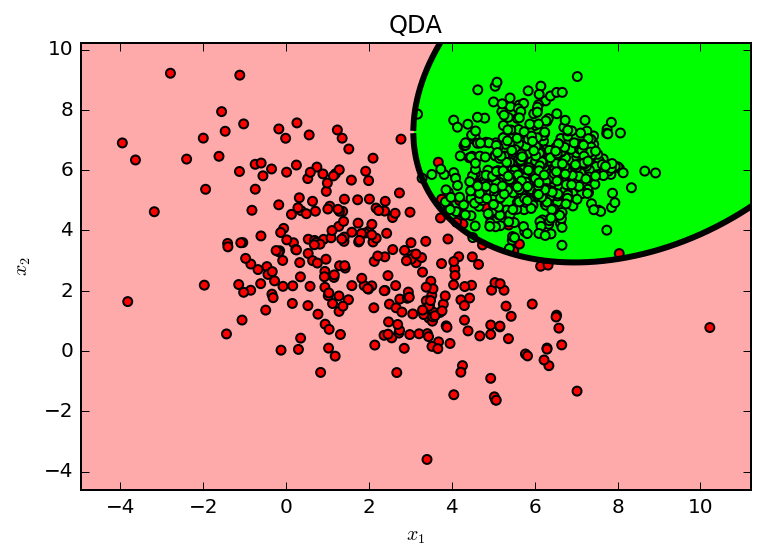

In [31]:
#QDA
def train_QDA(y,x):
    _,prob_class,mean_class,_,sigma_class = train_LDA(y,x)
    
    total_sample = float(len(y))
    total_class1 = float(len(y[y==1]))
    total_class2 = float(len(y[y==2]))
    
    prob_class1,prob_class2 = prob_class[0],prob_class[1]
    mean_class1,mean_class2 = mean_class[0],mean_class[1]
    cov_class1,cov_class2 = sigma_class[0],sigma_class[1]
    
    
    cov_qda_class1 = cov_class1/(total_class1-1)
    cov_qda_class2 = cov_class2/(total_class2-1)

    #Decision boundary! 

    C =-0.5*(  np.log(np.linalg.det(cov_qda_class1)/np.linalg.det(cov_qda_class2))
              + mean_class1.T.dot(np.linalg.inv(cov_qda_class1).dot(mean_class1)) 
              - mean_class2.T.dot(np.linalg.inv(cov_qda_class2).dot(mean_class2)) 
              - 2*np.log(prob_class1/prob_class2))

    B = (np.dot(np.linalg.inv(cov_qda_class1),mean_class1) - np.dot(np.linalg.inv(cov_qda_class2),mean_class2))
    A = -0.5*(np.linalg.inv(cov_qda_class1) - np.linalg.inv(cov_qda_class2))
    a,b,c,d,e,f = A[0][0], A[1][1], A[0][1] + A[1][0],B[0],B[1],C
    return a,b,c,d,e,f    

def test_QDA(x,a,b,c,d,e,f):
    aux1 = x.T[1] - (-c*x.T[0] - e + np.sqrt( (c*x.T[0] + e)**2 - 4*b*(a*x.T[0]**2 + d*x.T[0] + f)  ) )/(2*b)
    aux2 = x.T[1] - (-c*x.T[0] - e - np.sqrt( (c*x.T[0] + e)**2 - 4*b*(a*x.T[0]**2 + d*x.T[0] + f)  ) )/(2*b) 
    Z = np.zeros(len(aux1))
    for i in range(len(aux1)):
        if aux2[i]>=0 and aux1[i]<=0:
           Z[i]= 2
        else: 
           Z[i] = 1
    return Z

a,b,c,d,e,f = train_QDA(which_class,x)

decision_bound_QDA_1 = (-c*x_bound - e + np.sqrt( (c*x_bound + e)**2 - 4*b*(a*x_bound**2 + d*x_bound + f)  ) )/(2*b)
decision_bound_QDA_2 = (-c*x_bound - e - np.sqrt( (c*x_bound + e)**2 - 4*b*(a*x_bound**2 + d*x_bound + f)  ) )/(2*b)

Z = test_QDA(np.c_[xx.ravel(), yy.ravel()],a,b,c,d,e,f)
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(x[0], x[1], c=which_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.plot(x_bound,decision_bound_QDA_1,'k-',lw=3)
plt.plot(x_bound,decision_bound_QDA_2,'k-',lw=3)
plt.title('QDA')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()





Ahora en QDA, podemos ver que es distinta la decision boundary; como ecuación, obtuvimos una forma cuadrática (cónica), la cual, en su caso más general, es una elipse, como podemos ver. También, si evaluamos 'al ojo' nuestros clasificadores, claramente QDA supera a los dos métodos anteriores ya que encierra muchos menos puntos rojos en el área verde.

${\bf P2)}$

(10)-Nearest-Neighbours: Algoritmo muy famoso de clasificación; decidí usarlo ya que lo vimos en clases, $sabemos$ cómo varían las curvas de decisiones cambiando el número de vecinos y es de fácil implementación. El algoritmo, codificado ya en sklearn, no lo explicaremos, pero sí es fácil visualizar la idea básica principal. 

Observando la siguiente imagen:

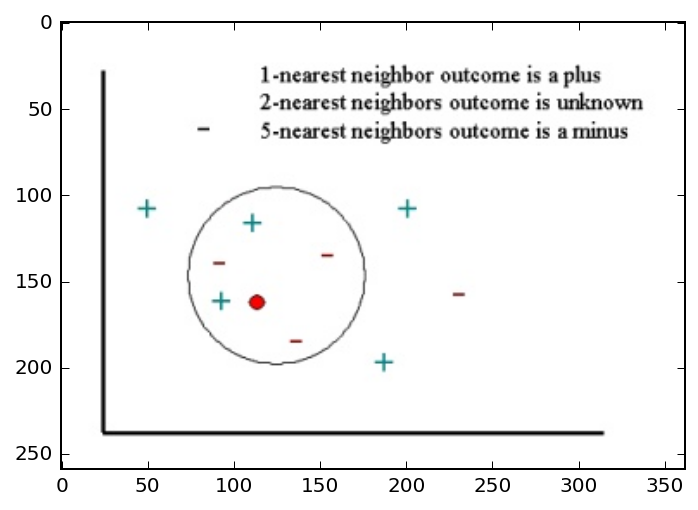

In [32]:
img=mpimg.imread('KNNOverViewImageA.jpg')
a = plt.imshow(img)

Notamos que el vecino más cercano al punto que queremos clasificar (rojo) es un signo '+', así que 1-NN lo clasificaría como '+'. Ahora bien, si asumimos que los pesos son uniformes en nuestro algoritmo (es decir, asumimos que solo nos interesa el número y no la distancia al punto a clasificar [más bajo se implementa con ${\bf \text{weights = 'distance'}}$]), 2-NN no sabría cómo clasificar el punto ya que los dos puntos más cercanos tienen clases distintas ('+' y '-'), y con 3-NN claramente se clasifica como '-'. 

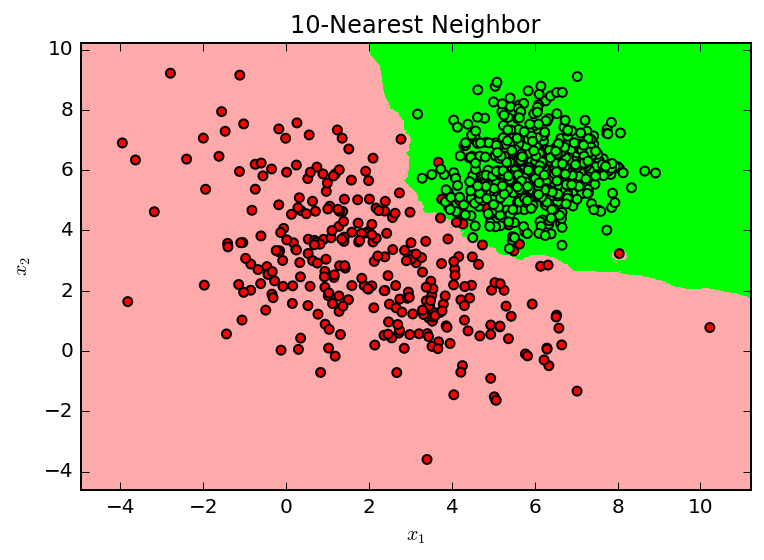

In [33]:
n_neighbors = 10

clf_knn = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf_knn.fit(x.T, which_class)

Z = clf_knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(x[0],x[1], c=which_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('10-Nearest Neighbor')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

Claramente podemos ver que ya no tenemos una elipse ni una recta; es un modelo un poco más complejo que los anteriores!.

Ahora bien, el segundo método de clasificación que usé fue Support Vector Machine; ¿por qué? Si bien no lo vimos en clases, me llamó bastante la atención y lo había escuchado antes y quería visualizar las diferencias con los otros clasificadores; además, es de fácil implementación:

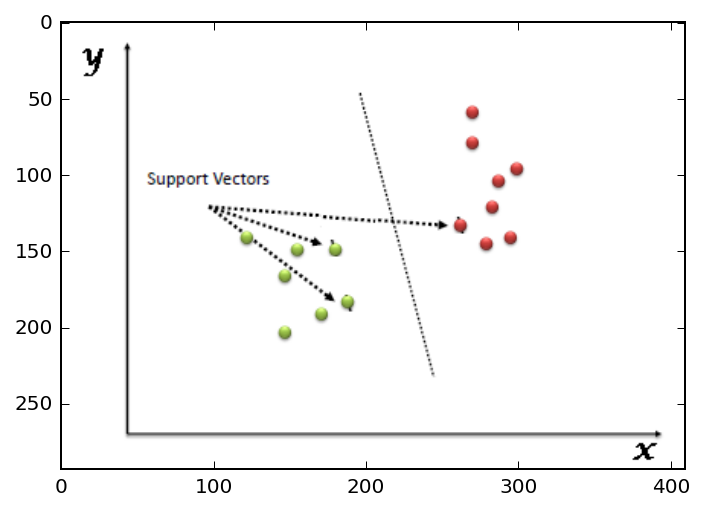

In [34]:
img=mpimg.imread('SVM_1.png')
imgplot = plt.imshow(img)

Básicamente lo que buscamos con SVM es encontrar el hiperplano que separa mejor nuestras clases, es decir, encontrar el hiperplano que esté a la $mayor$ distancia de cualquier punto de nuestro training set; esto, a la larga, es un problema de maximización que se puede resolver usando multiplicadores de Lagrange!; esta solución se generaliza para casos no lineales en donde se utilizan distinta clase de kernels para clasificar (más complejos, pero mucho más flexibles que una recta!), en nuestro caso, para mostrar la diferencia con LDA/regresión, utilizaremos un kernel gaussiano $({\bf \text{rbf = }\exp [{-\frac{1}{2} | \vec{x}_{i} - \vec{x}_{j} |^2 }} ] )$ con $C$, el término de penalización por misclassification, ALTO ($100$).

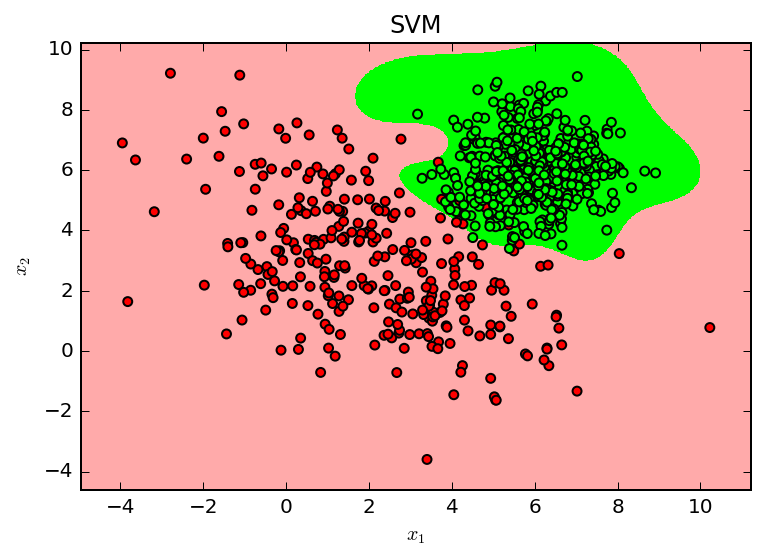

In [58]:
#SVM
clf_svm = svm.SVC(C = 100,kernel='rbf',gamma=0.5)
clf_svm.fit(x.T, which_class) 
Z = clf_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(x[0],x[1], c=which_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('SVM')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

Este sí que ya es sumamente distinto a los anteriores, ya que ahora podemos ver que define un área, que no es simétrica, cerrada, donde encierra los puntos correspondientes a la clase 2; como el término de penalización es alto, al entrenar a nuestro método, si bien es muy flexible (se nota), esperaríamos que no sea un buen clasificador!.

In [56]:
#Lo usaremos en P2) y P3) Haremos 15-Fold Cross validation para entrenar y testear nuestros clasificadores y así 
#matrices de confusión promedio para cada uno de ellos

def k_cross_val (x,y,classifier,folds=15):
    kf = KFold(len(x[0]), n_folds=folds, shuffle = True)    
    iterator = 0.
    misclass = 0.
    confusion = np.zeros((2,2))

    for train_index, test_index in kf:
        x_train, x_test = x.T[train_index], x.T[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if classifier == 'regression':
            params = train_linear_regression(y_train.T,x_train.T)
            y_pred = test_linear_regression(x_test,params)
        
        if classifier == 'KNN':
            clf_knn = neighbors.KNeighborsClassifier(10, weights='distance')
            clf_knn.fit(x_train, y_train) 
            y_pred = clf_knn.predict(x_test)
            
        if classifier == 'SVM':
            clf_svm = svm.SVC(C = 100,kernel='rbf',gamma=0.5)
            clf_svm.fit(x_train,y_train)
            y_pred = clf_svm.predict(x_test)
        
        if classifier == 'QDA':
            a,b,c,d,e,f = train_QDA(y_train.T,x_train.T)
            y_pred = test_QDA(x_test,a,b,c,d,e,f)
            
        if classifier == 'LDA':
            coeffs, prob_class, mean_class, sigma_all,sigma_class = train_LDA(y_train.T,x_train.T)
            y_pred = test_LDA(x_test,coeffs,prob_class,mean_class,sigma_all)
            
        if classifier == 'Bayes':    
            a,b,c,d,e,f = train_bayes(y_train.T,x_train.T)
            y_pred = test_bayes(x_test,a,b,c,d,e,f)

        cm = confusion_matrix(y_test, y_pred)/float(len(y_pred))
        confusion += cm        
    
    confusion /= float(folds)
    misclass = confusion[0][1] + confusion[1][0]
    return confusion, misclass

In [47]:
reg_confusion ,reg_misclass = k_cross_val(x,which_class,'regression')
print 'Regression:\n'
print 'Confusion Matrix: \n\n%s\n' % reg_confusion
print 'Misclassification Rate: %s' % reg_misclass

Regression:

Confusion Matrix: 

[[ 0.34863732  0.02629863]
 [ 0.          0.62506406]]

Misclassification Rate: 0.0262986256697


In [48]:
LDA_confusion ,LDA_misclass = k_cross_val(x,which_class,'LDA')
print 'LDA:\n'
print 'Confusion Matrix: \n\n%s\n' % LDA_confusion
print 'Misclassification Rate: %s' % LDA_misclass

LDA:

Confusion Matrix: 

[[ 0.3475658   0.02753319]
 [ 0.          0.624901  ]]

Misclassification Rate: 0.0275331935709


In [49]:
QDA_confusion ,QDA_misclass = k_cross_val(x,which_class,'QDA')
print 'QDA:\n'
print 'Confusion Matrix: \n\n%s\n' % QDA_confusion
print 'Misclassification Rate: %s' % QDA_misclass

QDA:

Confusion Matrix: 

[[ 0.35739576  0.01744701]
 [ 0.00251572  0.62264151]]

Misclassification Rate: 0.0199627300256


/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


In [50]:
KNN_confusion ,KNN_misclass = k_cross_val(x,which_class,'KNN')
print 'KNN:\n'
print 'Confusion Matrix: \n\n%s\n' % KNN_confusion
print 'Misclassification Rate: %s' % KNN_misclass

KNN:

Confusion Matrix: 

[[ 0.35394829  0.021174  ]
 [ 0.00125786  0.62361985]]

Misclassification Rate: 0.0224318658281


In [57]:
SVM_confusion ,SVM_misclass = k_cross_val(x,which_class,'SVM')
print 'SVM:\n'
print 'Confusion Matrix: \n\n%s\n' % SVM_confusion
print 'Misclassification Rate: %s' % SVM_misclass

SVM:

Confusion Matrix: 

[[ 0.35492662  0.02003261]
 [ 0.00498486  0.6200559 ]]

Misclassification Rate: 0.0250174703005


Viendo las matrices de confusión de cada clasificador, podemos asegurar, hasta ahora, que el mejor clasificador es QDA ya que tiene el menor misclassification rate (es decir, el que tiene mayor accuracy).

${\bf P3)}$ 

Si ahora sabemos que las distribuciones de las que provienen nuestros datos son gaussianas multivariadas con los parámetros enunciados, simplemente usamos QDA pero no estimamos los parámetros de las distribuciones ($\mu_k$, $\Sigma_k$), sólo las probabilidades a priori de la clase:

/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


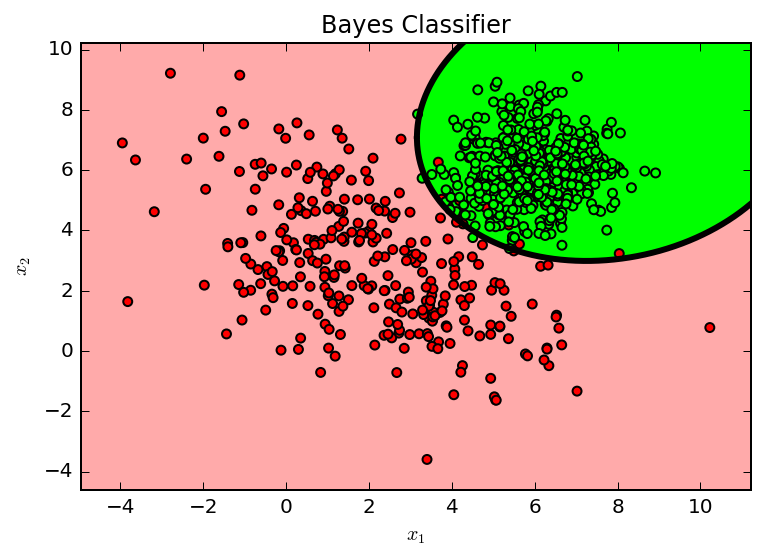

In [42]:
#Bayes Classifier

def train_bayes (y,x):
    total_sample = float(len(y))
    total_class1 = float(len(y[y==1]))
    total_class2 = float(len(y[y==2]))
    
    prob_class1 = total_class1/total_sample
    prob_class2 = total_class2/total_sample

    mean_class1,mean_class2 = np.array([2,3]),np.array([6,6])
    cov_qda_class1,cov_qda_class2 = np.array([[5,-2],[-2,5]]), np.array([[1,0],[0,1]])
    
    #cov_qda_class1 = cov_class1/(total_class1-1)
    #cov_qda_class2 = cov_class2/(total_class2-1)

    #Decision boundary! 

    C =-0.5*(  np.log(np.linalg.det(cov_qda_class1)/np.linalg.det(cov_qda_class2))
              + mean_class1.T.dot(np.linalg.inv(cov_qda_class1).dot(mean_class1)) 
              - mean_class2.T.dot(np.linalg.inv(cov_qda_class2).dot(mean_class2)) 
              - 2*np.log(prob_class1/prob_class2))

    B = (np.dot(np.linalg.inv(cov_qda_class1),mean_class1) - np.dot(np.linalg.inv(cov_qda_class2),mean_class2))
    A = -0.5*(np.linalg.inv(cov_qda_class1) - np.linalg.inv(cov_qda_class2))
    a,b,c,d,e,f = A[0][0], A[1][1], A[0][1] + A[1][0],B[0],B[1],C
    return a,b,c,d,e,f    

def test_bayes(x,a,b,c,d,e,f):
    aux1 = x.T[1] - (-c*x.T[0] - e + np.sqrt( (c*x.T[0] + e)**2 - 4*b*(a*x.T[0]**2 + d*x.T[0] + f)  ) )/(2*b)
    aux2 = x.T[1] - (-c*x.T[0] - e - np.sqrt( (c*x.T[0] + e)**2 - 4*b*(a*x.T[0]**2 + d*x.T[0] + f)  ) )/(2*b) 
    Z = np.zeros(len(aux1))
    for i in range(len(aux1)):
        if aux2[i]>=0 and aux1[i]<=0:
           Z[i]= 2
        else: 
           Z[i] = 1
    return Z

a,b,c,d,e,f = train_bayes(which_class,x)

decision_bound_bayes_1 = (-c*x_bound - e + np.sqrt( (c*x_bound + e)**2 - 4*b*(a*x_bound**2 + d*x_bound + f)  ) )/(2*b)
decision_bound_bayes_2 = (-c*x_bound - e - np.sqrt( (c*x_bound + e)**2 - 4*b*(a*x_bound**2 + d*x_bound + f)  ) )/(2*b)

Z = test_bayes(np.c_[xx.ravel(), yy.ravel()],a,b,c,d,e,f)
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(x[0], x[1], c=which_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.plot(x_bound,decision_bound_bayes_1,'k-',lw=3)
plt.plot(x_bound,decision_bound_bayes_2,'k-',lw=3)
plt.title('Bayes Classifier')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()
    

In [43]:
Bayes_confusion ,Bayes_misclass = k_cross_val(x,which_class,'Bayes')
print 'Bayes:\n'
print 'Confusion Matrix: \n\n%s\n' % Bayes_confusion
print 'Misclassification Rate: %s' % Bayes_misclass

Bayes:

Confusion Matrix: 

[[ 0.36116935  0.0137666 ]
 [ 0.00503145  0.62003261]]

Misclassification Rate: 0.0187980433263


/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in sqrt
/home/dafh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


Vemos que el Bayes Classifier es el que tiene menor Misclassification Rate, lo cual es lógico ya que sabemos los parámetros de las distribuciones!. Además, ahora podemos comprender por qué anteriormente QDA fue el mejor clasificador en P2) ya que las estimaciones de los parámetros están bastante cerca del parámetro real.


In [44]:
print 'Media Estimada:\n\n Clase 1 \t %s \n Clase 2\t %s' % (mean_class[0], mean_class[1])
print 'Matriz Covarianza:\n\n Clase 1 \t %s \n Clase 2\t %s' % (sigma_class[0]/len(x1[which_class==1]),sigma_class[1]/len(x2[which_class==2]))

Media Estimada:

 Clase 1 	 [ 2.09853143  2.91586115] 
 Clase 2	 [ 5.95399535  5.98593664]
Matriz Covarianza:

 Clase 1 	 [[ 4.95992936 -2.21008937]
 [-2.21008937  4.45675029]] 
 Clase 2	 [[ 0.97752027  0.07788406]
 [ 0.07788406  1.10234743]]
